# Image denoising

### Nuclear Norm Minimization

In [13]:
import numpy as np
from scipy.stats import bernoulli
from cvxpy import *

import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import imageio
import cv2

**Read image**

In [2]:
img = Image.open('cameraman.png').convert('L')

In [3]:
img = np.asarray(img)/255.

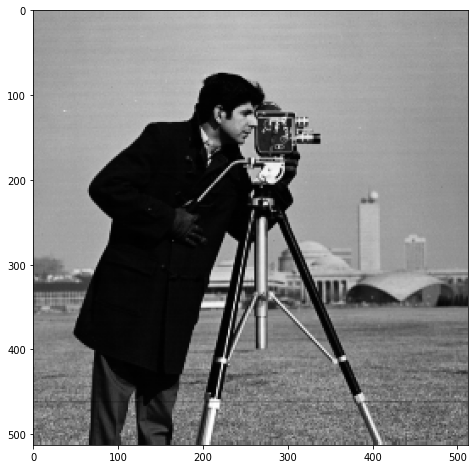

In [4]:
fig = plt.figure(figsize=[8,8])
plt.imshow(img, cmap='gray')
plt.show()

**Add noise**

In [5]:
def gen_mask(m, n, prob_masked=0.5):
    """
    Generate a binary mask for m x n matrix.
    Note that 1 denotes observed, and 0 denotes unobserved.
    """
    return 1 - bernoulli.rvs(p=prob_masked, size=(m, n))

In [6]:
def nuclear_norm_solve(A, mask, mu=1.0):
    """
    Solve using a nuclear norm approach, using CVXPY.
    [ Candes and Recht, 2009 ]
    Parameters:
    -----------
    A : m x n array
        matrix we want to complete
    mask : m x n array
        matrix with entries zero (if missing) or one (if present)
    mu : float
        hyperparameter controlling tradeoff between nuclear norm and square loss
    Returns:
    --------
    X: m x n array
        completed matrix
    """
    X = Variable(shape=A.shape)
    objective = Minimize(mu * norm(X, "nuc") +
                         sum_squares(multiply(mask, X - A)))
    problem = Problem(objective, [])
    problem.solve(solver=SCS)
    return X.value

In [7]:
def calc_unobserved_rmse(A, A_hat, mask):
    """
    Calculate RMSE on all unobserved entries in mask, for true matrix UVᵀ.
    Parameters
    ----------
    A : m x n array
        true  matrix
    A_hat : m x n array
        estimated matrix
    mask : m x n array
        matrix with entries zero (if missing) or one (if present)
    Returns:
    --------
    rmse : float
        root mean squared error over all unobserved entries
    """
    pred = np.multiply(A_hat, (1 - mask))
    truth = np.multiply(A, (1 - mask))
    cnt = np.sum(1 - mask)
    return (np.linalg.norm(pred - truth, "fro") ** 2 / cnt) ** 0.5


In [8]:
def plot_image(A, title=None):
    plt.imshow(A, cmap='gray')
    plt.title(title, fontsize=15)

In [9]:
def plot_proc(img1, img2, title):
    # Plot original image and denoised
    plt.figure(figsize=[20, 10])
    plt.subplot(121)
    plot_image(img1, 'True Image')

    plt.subplot(122)
    plot_image(img2, title)

True and noisy image

In [10]:
m, n = img.shape
mask = gen_mask(m,n, 0.5)
R = img*mask

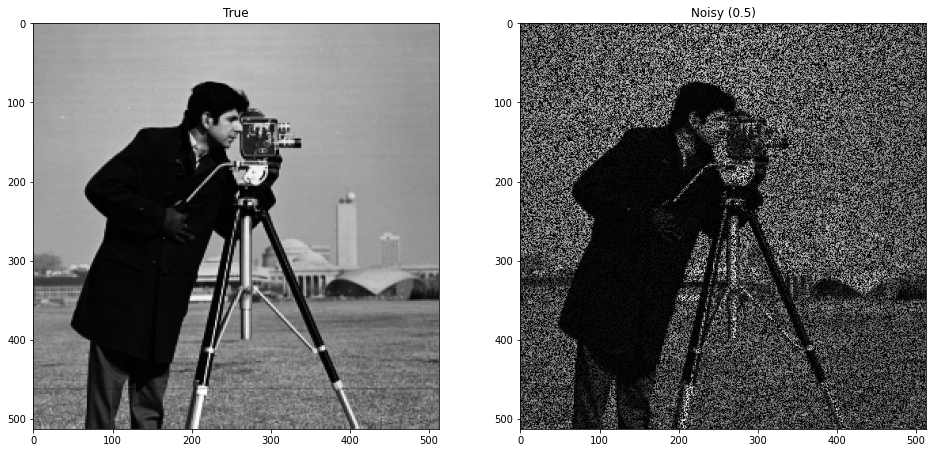

In [11]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[16,8])
axs[0].imshow(img, cmap='gray')
axs[0].set_title('True')
axs[1].imshow(R, cmap='gray')
axs[1].set_title('Noisy (0.5)')
plt.show()

**Solve NNM**

For several noise levels

NNM noise level 0.1, RMSE:0.026 and SSIM: 0.982
NNM noise level 0.2, RMSE:0.031 and SSIM: 0.974
NNM noise level 0.4, RMSE:0.043 and SSIM: 0.943
NNM noise level 0.5, RMSE:0.051 and SSIM: 0.915
NNM noise level 0.7, RMSE:0.075 and SSIM: 0.815


<Figure size 1440x720 with 0 Axes>

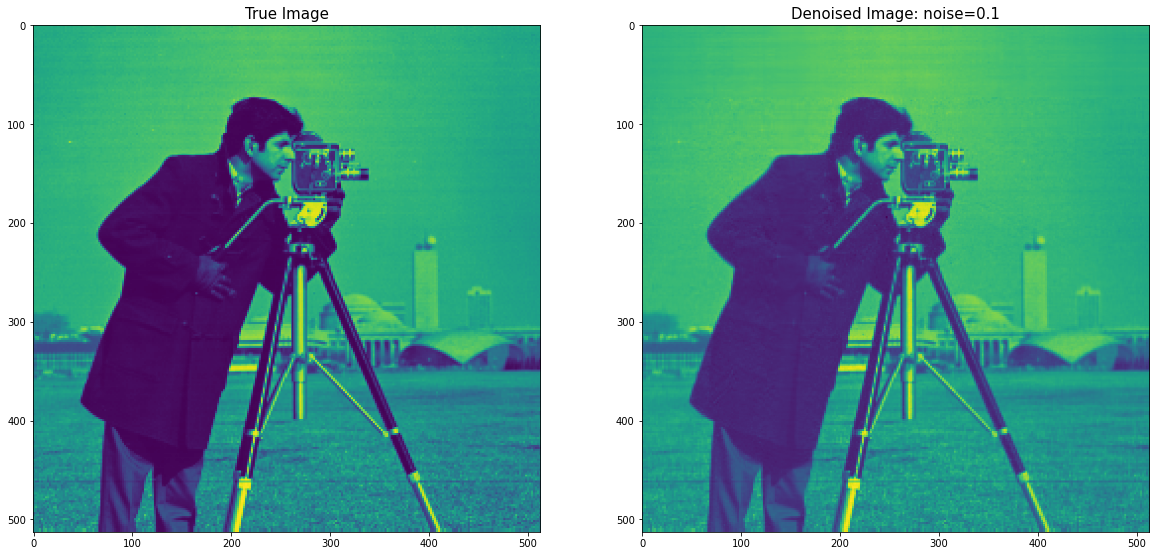

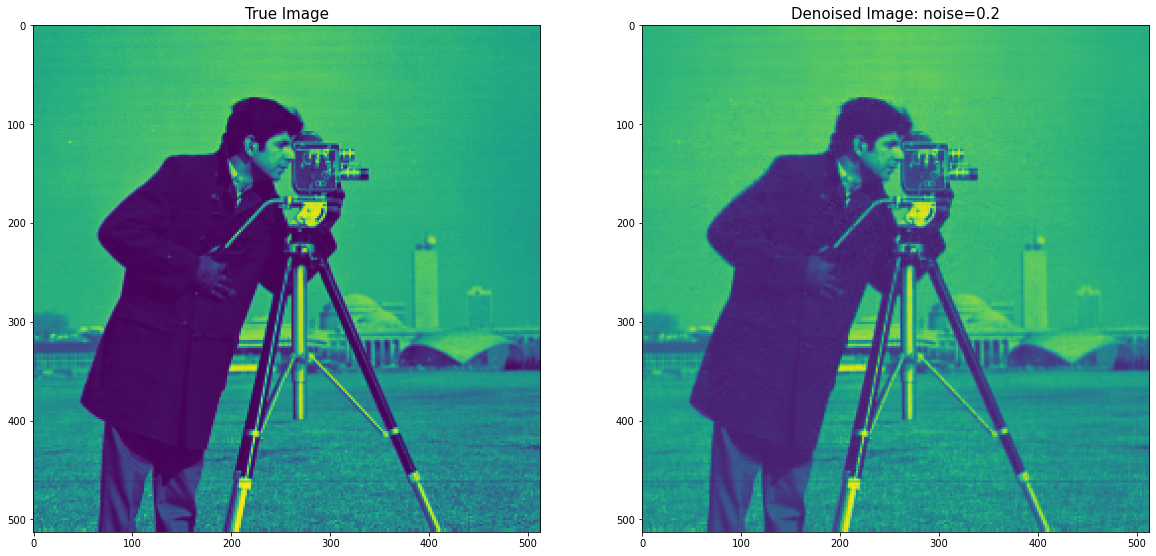

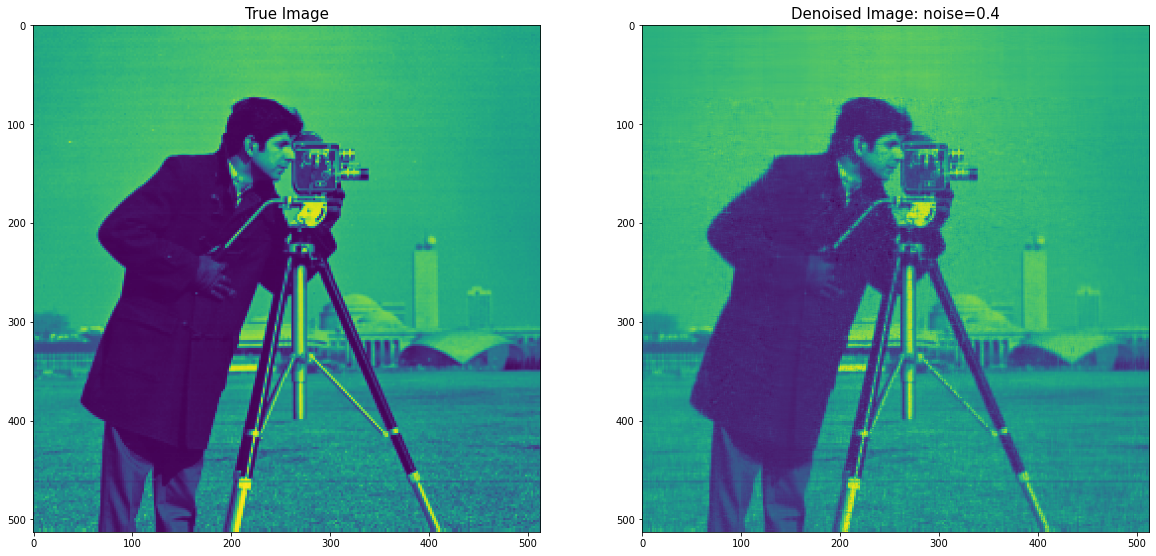

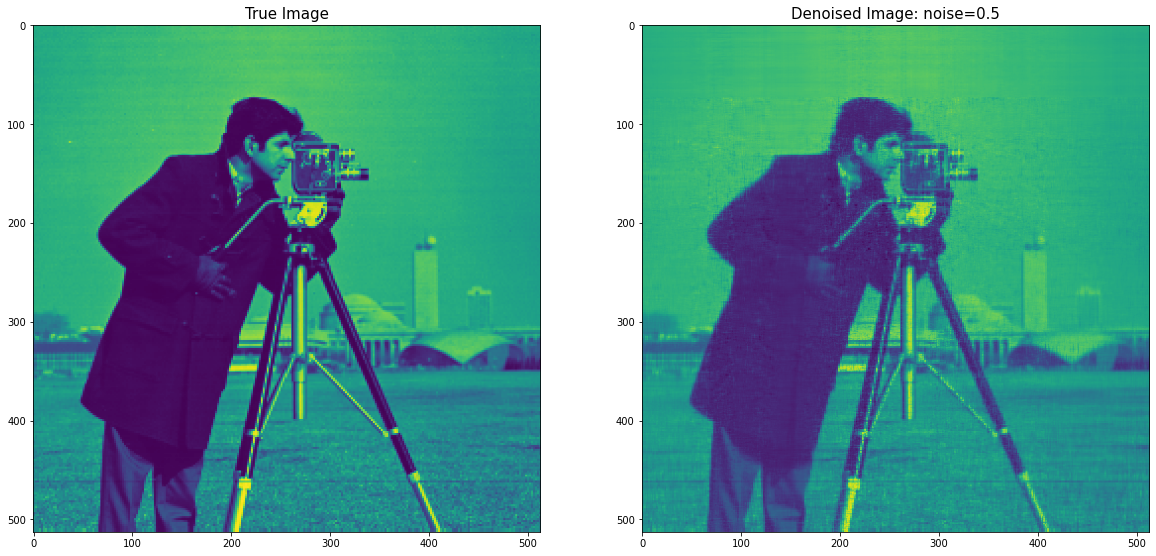

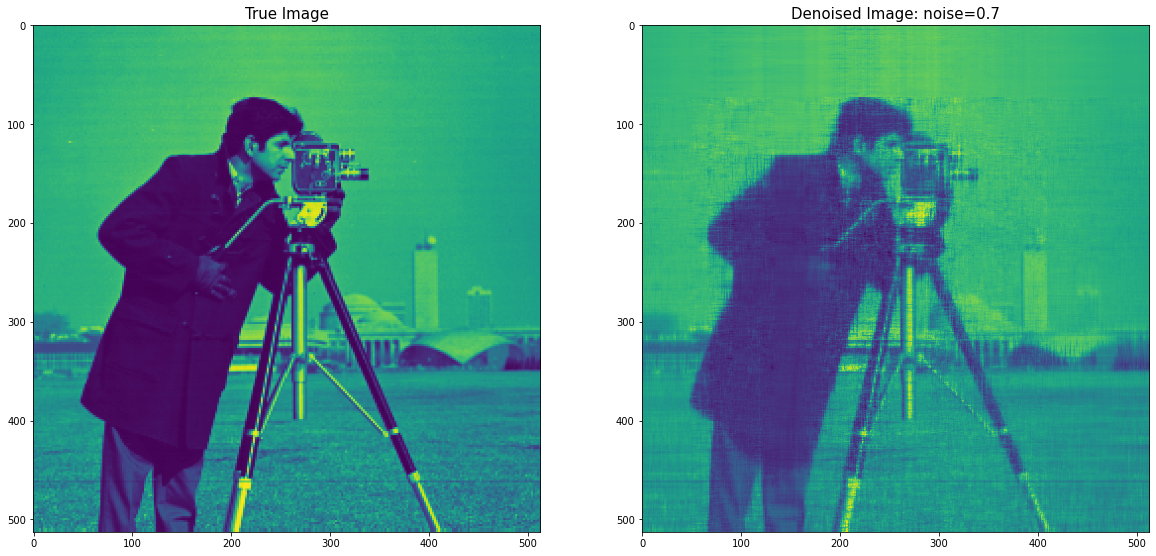

In [14]:
noise_level = [0.1, 0.2, 0.4, 0.5, 0.7]

plt.figure(figsize=(20, 10))
for i, nl in enumerate(noise_level):
    mask = gen_mask(m, n, nl)
    img_noisy = img*mask
    A = np.where(mask == 0, np.nan, img_noisy)
    
    A_hat = nuclear_norm_solve(A, mask)
    
    print("NNM noise level {}, RMSE:{:.3f} and SSIM: {:.3f}".format(nl, calc_unobserved_rmse(img, A_hat, mask), ssim(img,A_hat)))
    
    # Save noisy and denoised images
    #imageio.imwrite('imgNoisy_' +str(nl)+'.jpg', A)
    #imageio.imwrite('imgDenoised_' +str(nl)+'.jpg', A_hat)
    cv2.imwrite('imgNoisy_' +str(nl)+'.jpg', cv2.convertScaleAbs(A, alpha=(255.0)))
    cv2.imwrite('imgDenoised_' +str(nl)+'.jpg', cv2.convertScaleAbs(A_hat, alpha=(255.0)))
    
    # Visualize results
    plot_proc(img, A_hat, 'Denoised Image: noise='+str(nl))
    
plt.show()